In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rxr
import xarray as xr
import seaborn as sns
from matplotlib.patches import Rectangle


In [2]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rxr
import xarray as xr
import seaborn as sns
from matplotlib.patches import Rectangle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append(os.path.join(".."))
import joblib
import pytorch_lightning as pl
import torch
from src.model_utils import reshape_data, CroplandDatasetTest
from torch import nn
from torch.utils.data import DataLoader

### Defining paths 

In [3]:
# defining paths
path_to_npys_data = os.path.join("..", "data", "npys_data")

path_to_tifs = os.path.join("..", "data", "processed_files", "tifs")

pathTarget = os.path.join(path_to_npys_data, "target_croplands.npy")

transformer = os.path.join("..", "data", "results", "2040_2050", "transformer_ssp585_AVG_prob.npy")
lstm = os.path.join("..", "data", "results", "2040_2050", "lstm_ssp585_AVG_prob.npy")
conv_lstm = os.path.join("..", "data", "results", "2040_2050", "conv_lstm_ssp585_AVG_prob.npy")
mlp = os.path.join("..", "data", "results", "2040_2050", "mlp_ssp585_AVG_prob.npy")
catboost = os.path.join("..", "data", "results", "2040_2050", "catboost_ssp585_AVG_prob.npy")

path_to_figs = os.path.join("..", "data", "results", "prob_subs")


### Loading required datasets

In [4]:
# Loading GFSAD cropmask and use it as initial probability distribution. Class 4 denotes Nans in the dataset.

with open(pathTarget, 'rb') as f:
    init_data = pickle.load(f)
    tgt = init_data["Target"]
    # Set classes 4,5 to 0
    tgt[np.isnan(tgt)] = 6
    tgt = tgt.astype(np.int16)
    tgt = np.where(tgt == 5, 0, tgt)
    tgt = np.where(tgt == 4, 0, tgt)
    tgt = np.where(tgt == 6, 4, tgt)
    uniques = np.unique(tgt)
    n_values = len(uniques)
    tgt_ohe = np.eye(n_values)[tgt]
    init_data = tgt_ohe


In [5]:
# Load prediction and filters

# Predicted probabilites by LSTM model for 2050 year 
with open(lstm, 'rb') as f:
    lstm_prob = pickle.load(f)
    
with open(conv_lstm, 'rb') as f:
    conv_lstm_prob = pickle.load(f)

with open(transformer, 'rb') as f:
    transformer_prob = pickle.load(f)

with open(catboost, 'rb') as f:
    catboost_prob = pickle.load(f)

with open(mlp, 'rb') as f:
    mlp_prob = pickle.load(f)

# Tif file where 0s represent water area (no cropland is possible)
filter_water = rxr.open_rasterio(
    os.path.join(path_to_tifs, "filter_water.tif")
).squeeze()

# Tif file where 0s represent area with slope > 5 degrees (no cropland is possible)
filter_slope = rxr.open_rasterio(
    os.path.join(path_to_tifs, "filter_slope.tif")
).squeeze()


In [6]:
transformer_prob

array([[0.870695  , 0.00147027, 0.08551817, 0.04231654],
       [0.8694552 , 0.0014757 , 0.08643645, 0.04263267],
       [0.8734205 , 0.00140778, 0.08446594, 0.0407058 ],
       ...,
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan]], dtype=float32)

In [7]:
predicted_prob = (conv_lstm_prob + lstm_prob + mlp_prob + transformer_prob + catboost_prob) / 5
# predicted_prob = catboost_prob

In [8]:
predicted_prob

array([[9.58815669e-01, 6.57678577e-04, 2.09338009e-02, 1.95929049e-02],
       [9.60576388e-01, 6.68213390e-04, 2.02387963e-02, 1.85166555e-02],
       [9.64837972e-01, 6.77246952e-04, 1.97655407e-02, 1.47192317e-02],
       ...,
       [           nan,            nan,            nan,            nan],
       [           nan,            nan,            nan,            nan],
       [           nan,            nan,            nan,            nan]])

### Plot probabilities difference with initial cropmask for prediction

class diff 0


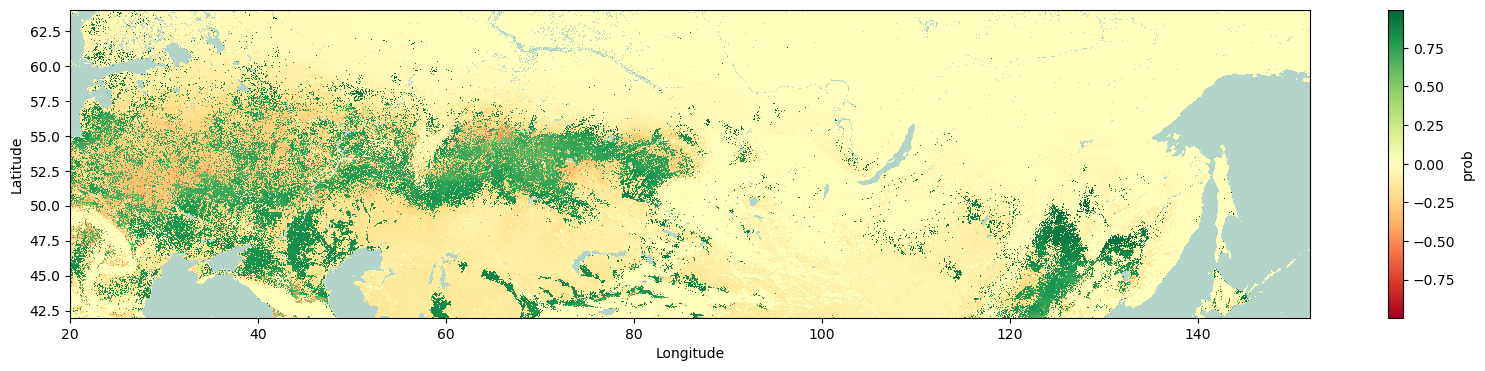

class diff 1


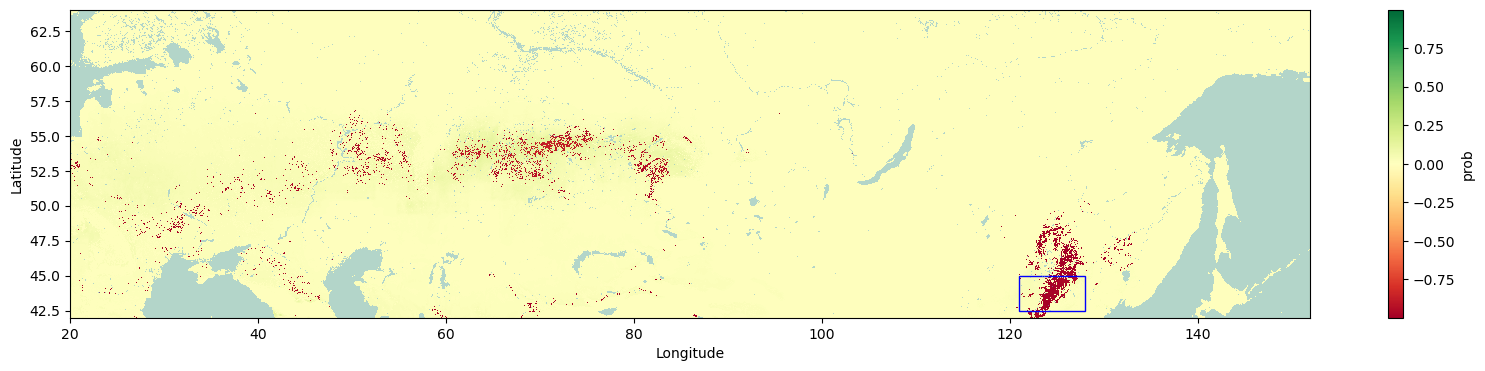

class diff 2


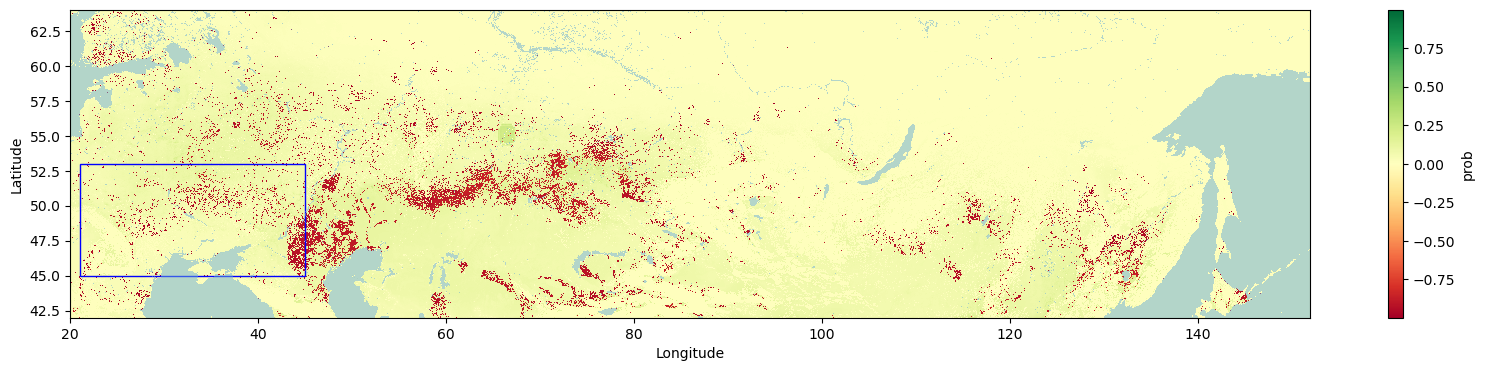

class diff 3


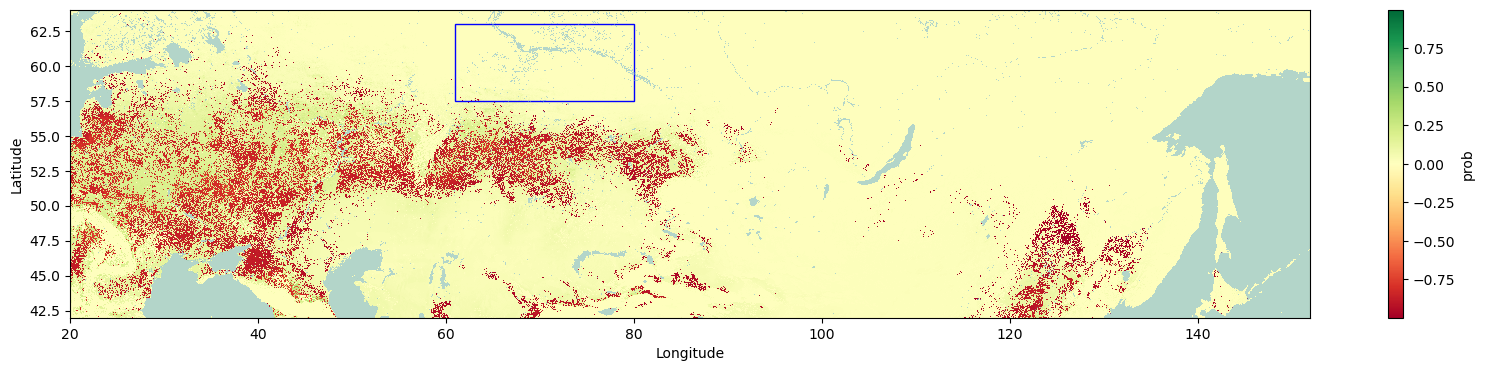

In [9]:
# Define dimensions for xr.DataArray based on Filter file:
x, y = filter_slope.indexes.values()
lot = y.shape[0]

# Plot heatmap for each class:
for j in range(4):
    predicted_prob_filtered = [
        z * h for z, h in zip(predicted_prob[:, j].reshape(lot, -1), filter_water.values)
    ]
    init_data_filtered = [
        z * h for z, h in zip(init_data[:, j].reshape(lot, -1), filter_water.values)
    ]
    predicted_prob_filtered = [z * h for z, h in zip(predicted_prob_filtered, filter_slope.values)]
    init_data_filtered = [z * h for z, h in zip(init_data_filtered, filter_slope.values)]

    diff_probability = np.subtract(predicted_prob_filtered, init_data_filtered)
    diff_probability = diff_probability.reshape(-1)
    
    # Add rectangles
    rectangles = [(45, 121, 42.5, 128),   # [ul_corner_y, ul_corner_x, lr_corner_y, lr_corner_x]
                (53, 21, 45, 45),
                (63, 61, 57.5, 80)]
    
    filter_water_ = filter_water.where(filter_water == 0)
    diff_probability = xr.DataArray(
        diff_probability.reshape(lot, -1), dims=["y", "x"], coords=dict(y=y, x=x)
    )
    diff_probability.name = 'prob'

    # Plotting
    fig, gax = plt.subplots(figsize=(20, 4))
    
    # Plot rectangle
    if j != 0:
        ul_corner_y, ul_corner_x, lr_corner_y, lr_corner_x = rectangles[j-1]
        width = lr_corner_x - ul_corner_x
        height = lr_corner_y - ul_corner_y
        rect = Rectangle((ul_corner_x, ul_corner_y), width, height, linewidth=1, edgecolor='b', facecolor='none')
        gax.add_patch(rect)
        
    # Plot heatmap    
    filter_water_.plot(ax=gax, cmap='Blues', add_colorbar=False, alpha=0.5)
    diff_probability.plot.imshow(ax=gax, cmap='RdYlGn')
    # plt.savefig(os.path.join(path_to_figs, 'lstm_ssp245_average_class_diff_' + str(j) + '.png'))
    print('class diff ' + str(j))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
    plt.close(fig)
